## Clean up the House Data from Hemnet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime 

The dataset contains Latin characters like å,ä,ö so we need to open it with latin-1 encoding

In [2]:
#open the dataset
with open('../data/170829/houses.csv',encoding='latin-1') as f:
    df = pd.read_csv(f)

Get a feel for the dataset

In [3]:
#get the shape
df.shape

(1173, 12)

In [4]:
#describe the features to get a feel for the data
df.describe()

,area,sup_area,rooms,land_area,monthly_fee,price_change_pct,price
count,1161.000000,615.000000,1154.000000,915.000000,248.000000,1013.000000,1.173000e+03
mean,133.893712,48.402602,5.302860,708.743497,4732.528226,8.883514,5.728539e+06
std,40.052265,38.854796,1.463461,547.847411,1024.506335,9.621403,2.330008e+06
min,35.000000,1.500000,1.500000,101.000000,2095.000000,-16.000000,1.450000e+06
25%,108.000000,15.000000,4.000000,251.000000,4105.000000,2.000000,4.070000e+06
50%,127.000000,38.000000,5.000000,715.000000,4656.000000,8.000000,5.450000e+06
75%,157.000000,74.500000,6.000000,1018.000000,5301.000000,15.000000,7.000000e+06
max,500.000000,291.000000,14.000000,9106.000000,7993.000000,57.000000,2.117500e+07


In [5]:
df.count()

house_type          1173
address             1172
region              1162
area                1161
sup_area             615
rooms               1154
land_area            915
monthly_fee          248
date_sold           1173
broker              1173
price_change_pct    1013
price               1173
dtype: int64

We have a lot of missing values, some bad data, and a few unneccessary columns

- **Unnamed:** just an index column
    - id: we really dont need this for later, but for now, rename so we can use it to easily remove unique items 

- **house_type:** type of house
    - category: Villa/Radhus

- **address:** address of sold house
    - string value
    - one missing value
    - also noticed on inspection some weird values like "inställd"

- **region:** region where the house is 
    - category
    - this data is messy, need to consolidate to fewer regions
    - missing values can be inferred from address

- **area:** house area in sq metres
    - numeric, continuous
    - some missing values, seems like an important feature so may scrap rows with missing values

- **sup_area:** auxiliary area in sq metres
    - numeric, continuous
    - some missing values, these should probably be 0

- **rooms:** # rooms in the house
    - numeric, discrete
    - some missing values, maybe we can estimate from area

- **land_area:** land area in sq metres
    - numeric, continuous
    - some missing values, only houses with no listing_fee seem to have values which makes sense since you don't own the property when you have a monthly_fee (condominium), we can set this to 0 for now, but should probably categorize this

- **listing_fee:** montly fee in kr (for condominium/bostadsrätt)
    - numeric, contiuous
    - some missing values, set to 0, this is normal, if it is not a condominium you dont have a listing fee, could be used to categorize though

- **date_sold:** the date the house was sold
    - date
    - later we should probably split this up to see seasonality

- **broker** the broker firm that sold the house
    - string, category
    - no missing values
    - could be interesting to see if some broker firms have "lockpriser", i.e. if the sales price is much higher than the list price
    - could also partially gleen from this if the house is new construction (but not for sure)

- **price_change_pct:** how many percent this price went up or down from the listing price
    - numeric, continuous
    - pos/neg
    - missing values are likely 0s

- **price:** this is the price in thousand kr that the house sold for
    - numeric, continuous
    - no missing values
    - this is our target value

In [6]:
df.head(5)

,house_type,address,region,area,sup_area,rooms,land_area,monthly_fee,date_sold,broker,price_change_pct,price
0,Villa,Lilla Slingan 36,Viby,155.0,NaN,6.0,1232.0,NaN,2017-08-29,Fastighetsbyrån Sollentuna,3.0,7700000
1,Radhus,Fjärdingsmansvägen 186,Norrviken,107.0,10.0,5.0,208.0,NaN,2017-08-28,Bjurfors Sollentuna,11.0,4765000
2,Villa,Dianavägen 9,Edsviken,208.0,22.0,9.0,1003.0,NaN,2017-08-28,Susanne Persson Fastighetsförmedling AB,2.0,12700000
3,Villa,Strandpromenaden 9,Norrviken,190.0,103.0,8.0,1389.0,NaN,2017-08-25,Susanne Persson Fastighetsförmedling AB,12.0,12000000
4,Villa,Valkyrievägen 9,Edsviken,198.0,91.0,7.0,1160.0,NaN,2017-08-25,Susanne Persson Fastighetsförmedling AB,1.0,12100000


## Numeric values

### Unnamed
just an index column that we won't need, we could drop it, but for now, let's keep and rename to index

In [7]:
df.columns.values[0]='index'
# IF WE WANTED TO DROP INSTEAD
#df.drop(df.columns[[0]], axis=1, inplace=True)

In [8]:
#look for missing values
df.count()

index               1173
address             1172
region              1162
area                1161
sup_area             615
rooms               1154
land_area            915
monthly_fee          248
date_sold           1173
broker              1173
price_change_pct    1013
price               1173
dtype: int64

## Area
The size of the house in square metres

### Missing values
Here we have a lot of missing values

I suspect that the area is very relevant for the price.  And if we correlate the area to the price though we notice that there is a very strong positive correlation (i.e. the price is very very dependent on area) and we have nothing we can use to estimate it, so let's drop all the rows with null values

In [9]:
def scatter_vs_price(var):
    data = pd.concat([df['price'], df[var]], axis=1)
    data.plot.scatter(x=var, y='price', ylim=(0,25000000));
    plt.show()

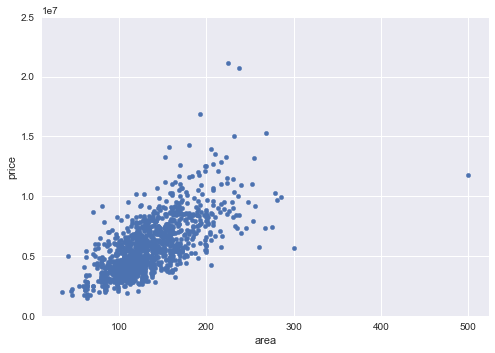

In [10]:
#show a scatterplot to see correlation
scatter_vs_price('area')

In [11]:
#area has missing values, drop all rows without area - too important
df = df.dropna(subset=['area'])

### Outliers

Actually, there are some outliers too (500 sqm), we need to investigate this more

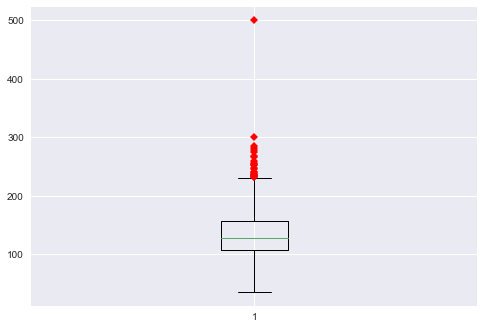

In [ ]:
plt.boxplot(df['area'], 0, 'rD')
plt.show()

In [ ]:
df[df.area > 450]

This sale is odd (not representative) so it will skew our data.  A house in Edsviken (most expensive area in Sollentuna) that is 500 sq m (very large) and has 14 rooms, should have been around 14-15 million.  We can see that it went down a whole 9% from its listing price - so they thought it was worth 14.5 million too - something is very wrong here, so let's remove it

In [ ]:
#remove any rows with area above 450
df = df[df.area < 450]

In [ ]:
scatter_vs_price('area')

## Sup_Area

This is the auxilliary area in sq metres - i.e. the "biarea" - area that can't be counted as main area because it is too far away from a window.  Typically this is worth a little less than "real" area but should still correlate well with price.

### Missing values

It is normal for this to have missing values (for houses with no basement or sub-terranian area).  Any missing values can be replaced with 0s

In [ ]:
#missing sup_are should have sup_area = 0
df['sup_area'].fillna(0, inplace=True)

In [ ]:
scatter_vs_price('sup_area')

### Outliers

Here we have some outliers too that we should check out.  Unless you have a gigantic house, it is weird to have that much aux area

In [ ]:
plt.boxplot(df['sup_area'], 0, 'rD')
plt.show()

In [ ]:
df[df.sup_area > 200]

Not exactly sure what is going on here... the houses seem gigantic and the total area doesn't seem to match the street view in maps, but we'll leave them for now and see if they are really outliers later (may combine area + sub_area) 

## Monthly_fee (Bostadsrättsavgift)

Monthly fee in kr

### Missing Values

Not having a monthly fee is normal, montly fees only apply to bostadsrätt so we can safely set nulls to 0

In [ ]:
#missing listing_fee is normal - set to 0
df['monthly_fee'].fillna(0, inplace=True)

In [ ]:
scatter_vs_price('monthly_fee')

### Outliers

We don't seem to have any outliers per see, but we do have an interesting situation (and I could have predicted this "by hand")
Houses that have a montly fee, i.e. houses that you don't fully own, go for a lot less than property you own. 

There is such a big distinction that we should probably separate them out completely later and do two different models

In fact, let's create a new column called is_condo based on this

In [ ]:
df['is_condo'] = df['monthly_fee'].apply(lambda fee: 0 if fee == 0 else 1)

## Price_change_pct

This is the % the price went up or down compared to the listing price.  It will be interesting to see how this fluctuates over time later.

### Missing 

Any missing values means that it sold for the listing price, so we can safely set missing to 0

In [ ]:
#missing price_change_pct means no change = 0
df['price_change_pct'].fillna(0, inplace=True)

In [ ]:
scatter_vs_price('price_change_pct')

It looks like there is literally no correlation between the price and how much it went up or down. It's all over the place.

We may just remove this feature... but I want to keep it until we start investigating the values to see if there is a year on year correlation... 

And I am very curious about the ones where the price went up significantly, so let's just list the ones that went up more than 35%

In [ ]:
df[df.price_change_pct > 35]

Can't find a pattern right now, but let's keep it for later

## Land_area

This is the number of sq metres of land that comes with the property

Let's first scatter this for all non-empty values

In [ ]:
scatter_vs_price('land_area')

it actually seems to have a nice correlation with the price, except for a couple of weird things

1. some values around 3000 square metres that don't follow the correlation
2. a massive outlier at around 9500 metres... that is probably some type of agricultural property. Way out of the norm so it will likely skew our data and we should remove it. 

### Missing values

Missing values here mean that we don't own the property... we can set this to 0, but... we should really separate the ones with listing_fee into a separate model

In [ ]:
#filling land_area with = seems legit
df['land_area'].fillna(0, inplace=True)

### Outliers

Ok, let's check out the weird properties... we can list anything with a land area over 2800 maybe

In [ ]:
df[df.land_area > 2800]

The top one [125] and the bottom 2 [675, 1152] are obviously sold for land value (fairly low prices and small houses given the land)

The other 2 are really nice large "luxury" houses with large grounds 
    [357] is right on the lake with it's own boat dock 
    [418] has a large pool 
(we can see that on sattelite maps)

We may need to either 
    A. gather that type of data later since it will probably be significant for the price or 
    B. remove really expensive houses... but we'll look at that later

For now we remove the properties we suspect are sold for land value

In [ ]:
df = df[df['index'].isin([125,675,1152]) == False]

In [ ]:
df[df.land_area > 2800]

In [ ]:
# let's just scatter it again
scatter_vs_price('land_area')

## Rooms

The number of rooms in the house. While it is kinda a continuous number it is actually more discrete so scatter plots will look a bit funky.

In [ ]:
scatter_vs_price('rooms')

The number of rooms correlate nicely with price except for the houses that are over 20 million... we'll see... maybe we'll eventually remove those houses... when houses get that expensive they seem to follow other critierias  (i'm guessing they are probably all by the lake)

Let's ignore them for now

### Missing values

We do have a bunch of missing values though so let's investigate them

In [ ]:
#what's up with the NaN rooms?
df[pd.isnull(df['rooms'])]

In [ ]:
#let's look at room distribution to see if we can figure out approx how many rooms they should have 
#scatter plot grlivarea/saleprice
data = pd.concat([df['rooms'], df['area']], axis=1)
data.plot.scatter(x='area', y='rooms', ylim=(0,15))
plt.show()

The correlation is very high, but still hard to make out how many sq metres an average room is.
Let's do something a little different... 

I wonder if we get an even higher correlation if we look at the total_area = area + sup_area

In [ ]:
# let's add a new column that is the sum of the area and the sup_area
df['total_area'] = df.apply(lambda row: row['area'] + row['sup_area'], axis=1)

In [ ]:
# ...and then we can look at that scatter plot
data = pd.concat([df['rooms'], df['total_area']], axis=1)
data.plot.scatter(x='total_area', y='rooms', ylim=(0,15))
plt.show()

meh... but... take a look at that **outlier** almost 600 sq metres, that's a huge house

In [ ]:
df[df.total_area > 500]

let's scatter that against the price to see if it is behaving weirdly

In [ ]:
scatter_vs_price('total_area')

In [ ]:
plt.boxplot(df['total_area'], 0, 'rD')
plt.show()

may as well remove it, it is just way off

In [ ]:
df = df[df.total_area < 500]

ok, back to the missing values in the room column

one thing we could do is just copy the # of rooms of the houses with the closest total area

In [ ]:
#very high linear corr - let's sort by total_area and fill with prev number
df.sort_values(by=['total_area', 'area'], inplace=True)
df['rooms'].fillna(method='pad', inplace=True)
df.head(5)

oki, I think we're done with the numerical values... let's just check the counts

In [ ]:
df.count()

And just a quick peak at the histograms

In [ ]:
#we're done with the numerical values, let's check the histograms
df.hist()
plt.show()

# Categorical Values

## House_Type

The house type is either "Villa" = Detached House or "Radhus" = Townhome 
and we have no null values.

In [ ]:
df['house_type'].describe()

In [ ]:
df.house_type.unique()

In [ ]:
counts = df['house_type'].value_counts()
counts

In [ ]:
fig, ax = plt.subplots()
df['house_type'].value_counts().plot(ax=ax, kind='bar')
plt.show()

## Region

Region is a total mess

In [ ]:
df['region'].describe()

In [ ]:
df.region.unique()

In [ ]:
counts = df['region'].value_counts()
counts

We have 67 different regions... lots of them with only one house sale

We need to consolidate these regions - Östra Viby should be renamed Viby, and all the Gillbo entries are in Rotebro etc.
(Most of the regions I can map because I live here, and for the rest I use a map and check the location)

I decided to "bin" them into 20 different regions. May consolidate a few later or even split them out

In [1]:
def Clean_Region(region):
    if "Rotsunda" in region:
        return "Rotsunda"
    elif "Rotebro" in region or "Gillbo" in region or "Gillberga" in region:
        return "Rotebro"
    elif "Norrviken" in region:
        return "Norrviken"
    elif "Viby" in region:
        return "Viby"
    elif "Törnskogen" in region or "Solängen" in region or "Väsjön" in region or "Vaxmora" in region or "Waxmora" in region or "Södersättra" in region:
        return "Törnskogen"
    elif "Edsberg" in region or "Tunberget" in region or "Edsängen" in region:
        return "Edsberg"
    elif "Kvarnskogen" in region:
        return "Kvarnskogen"
    elif "Landsnora" in region:
        return "Landsnora"
    elif "Falkberget" in region:
        return "Falkberget"
    elif "Kärrdal" in region:
        return "Kärrdal"
    elif "Sjöberg" in region:
        return "Sjöberg"
    elif "Edsviken" in region:
        return "Edsviken"
    elif "Edsbacka" in region or "Tureberg" in region:
        return "Tureberg"
    elif "Skälby" in region or "Häggvik" in region:
        return "Häggvik"
    elif "Töjnan" in region or "Hästhagen" in region:
        return "Töjnan"
    elif "Fågelsången" in region:
        return "Fågelsången"
    elif "Helenelund" in region:
        return "Helenelund"
    elif "Tegelhagen" in region:
        return "Tegelhagen"
    elif "Silverdal" in region:
        return "Silverdal"
    elif "Sollentuna" in region or "SOLLENTUNA" in region:
        return "Sollentuna Centrum"
    else:
        return None

In [ ]:
df['region'].fillna("UNKNOWN", inplace=True)

In [ ]:
df['clean_region'] = df.apply(lambda row: Clean_Region(row['region']), axis=1)

In [ ]:
df.head(5)

In [ ]:
counts = df['clean_region'].value_counts()
counts

In [ ]:
df['clean_region'].describe()

### Missing values

There are actually quite a few missing values here, but given the address we can manually map them

In [ ]:
#missing regions
df[pd.isnull(df['clean_region'])]

In [ ]:
df.loc[df['address'] == "Rösjövägen 86", "clean_region"] = "Rösjön"
df.loc[df['address'] == "Limavägen 3", "clean_region"] = "Norrviken"
df.loc[df['address'] == "Kantorsgränd 6", "clean_region"] = "Norrviken"
df.loc[df['address'] == "Hedemoravägen 107", "clean_region"] = "Viby"
df.loc[df['address'] == "Lomvägen 187", "clean_region"] = "Kärrdal"
df.loc[df['address'] == "Grönanvägen 2", "clean_region"] = "Törnskogen"
df.loc[df['address'] == "Malungsvägen 275", "clean_region"] = "Viby"
df.loc[df['address'] == "Lilla Slingan 10", "clean_region"] = "Viby"
df.loc[df['address'] == "Holmbodavägen 19", "clean_region"] = "Rotebro"
df.loc[df['address'] == "Skillingevägen 10A", "clean_region"] = "Viby"
df.loc[df['address'] == "Falkbergsvägen 6", "clean_region"] = "Landsnora"
df.loc[df['address'] == "Eriksbergsvägen 24B", "clean_region"] = "Fågelsången"

Now we have no missing regions

In [ ]:
df['clean_region'].describe()

In [ ]:
counts = df['clean_region'].value_counts()
counts

In [ ]:
fig, ax = plt.subplots()
df['clean_region'].value_counts().plot(ax=ax, kind='bar')
plt.show()

Given how few samples we have for Falkberget for example, this will really skew things... we might move that one to Kärrdal (closest)

But... now we're done and can drop the region column

In [ ]:
#drop the region column
del df['region']

## Address

The address may be a really useful column for if we want to gather more data.  Like how close it is to a lake or the town center.  

For prediction purposes though it will be pretty useless since it is rather unique

### Missing values

We can choose to keep the one item with missing address (since it wont matter for prediction)
If we need to consolidate with other data sources we might drop the row with null values though... 

### Potential Feature Engineering

One interesting thing we could do here is to split out the streetname - won't do this now, but that could help us later

In [ ]:
#df[pd.isnull(df['address'])]

In [ ]:
# we could drop the empty address row
#df = df.dropna(subset=['address'])

## date_sold

This is the date the house was sold...

I have some ideas that the price may vary on 

1. how long ago the house was sold 
2. what time of year (summer, winter, before vacation etc.)
    
We could potentially also correlate by date to 

1. interest rates
2. before or after the requirement to pay off your debt (not just interest) - June 1, 2016

The date can also be used to identify the sale in the taxation data from Skatteverket

### Missing values

No missing values

### Feature engineering

For now, let's keep the date but also
1. extract the year
2. extract the month

later on we should probably add a column for after_amort (after the amortization law)

In [ ]:
df['date_sold'] = pd.to_datetime(df['date_sold'])
df['year'] = df['date_sold'].dt.year
df['month'] = df['date_sold'].dt.month

In [ ]:
fig, ax = plt.subplots()
df['year'].value_counts().plot(ax=ax, kind='bar')
plt.show()

In [ ]:
fig, ax = plt.subplots()
df['month'].value_counts().plot(ax=ax, kind='bar')
plt.show()

We have a definite seasonality here... most houses are sold in 

- spring/summer [April,May,June] peaking in May (people start wanting a bigger yard etc.) and 
- autum [September, October] (when things are pretty calm)

christmas [December] and middle of summer vacation [July] are low times... will be interesting to see how that affects price

## broker

Brokers like to "up-play" their importantce for the sale IMHO... will be interesting to see how relevant they really are. 
And also to check if there is a correlation between broker and how much the price goes up/down from listing... are some brokers setting the listing price low to "suck you in"

In [ ]:
df['broker'].describe()

In [ ]:
counts = df['broker'].value_counts()
counts

we have too many differnet ones though... let's remove the city part from the names (since it's the same broker, just different location)

In [ ]:
df['clean_broker'] = df.apply(lambda row: row['broker'].replace("i Sollentuna", "").replace("Sollentuna", "").replace("Vallentuna", "").replace("Täby", "").replace("Upplands Väsby", "").replace("Vällingby-Hässelby", "").replace("Stockholm Innerstan", "").replace("Roslagen", "").strip(), axis=1)

In [ ]:
fig, ax = plt.subplots()
df['clean_broker'].value_counts().plot(ax=ax, kind='bar')
plt.show()

In [ ]:
#drop the broker column
df.drop(df.columns[[9]], axis=1, inplace=True)

And we are done cleaning all the features

In [ ]:
df.count()

## price

finally, let's have a look at the sales price (in kr)

In [ ]:
df['price'].describe()

Let's turn it into kkr (thousands of kr) to make it easier to read

In [ ]:
df['price'] = df.apply(lambda row: row.price/1000, axis=1)

In [ ]:
#histogram
sns.distplot(df['price']);
plt.show()

We'll explore it more in the data exploration part - for now it is enough to know that we have all the values

In [ ]:
plt.boxplot(df['price'], 0, 'rD')
plt.show()

### outliers
We have a few houses that really stand out (the ones over 20 mill) - let's remove them since very few houses in this area will have that price

In [ ]:
df = df[df.price < 20000]

In [ ]:
#drop the index column
try:
    del df['index']
except:
    pass

rename clean_region to region and clean_broker to broker

In [ ]:
df.columns.values[12]='region'
df.columns.values[15]='broker'
df.head(5)

Finally, lets just save the clean data

In [ ]:
df.to_csv('../data/170829/cleanhouses.csv')